<a href="https://colab.research.google.com/github/Tbarkin121/ML_Examples/blob/main/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Useful Resources : 
https://blog.keras.io/building-autoencoders-in-keras.html


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math

import keras
from keras.callbacks import TensorBoard
from keras import layers
from keras import models
from keras.layers import Dropout, LeakyReLU, ReLU, ELU
from keras.utils.vis_utils import plot_model
from PIL import Image

import random
np.random.seed(42)

4423680/4422102 [==============================] - 0s 0us/step
Input shape = 
(60000, 32, 32, 1)

Data type = 
<class 'numpy.float32'>



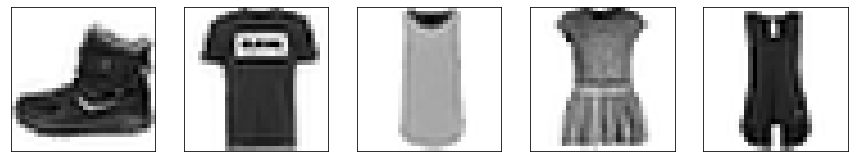

(32, 32, 1)


In [2]:
from keras.utils import to_categorical
from sklearn.utils.multiclass import unique_labels

class Environment:
    def __init__(self, dataset = tf.keras.datasets.fashion_mnist):
      (self.train_images, self.train_labels), (self.test_images, self.test_labels) = dataset.load_data()
      # Hardcoding label names for the fashion_mnist dataset 
      self.class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
      self.preprocess_data()

    def Change_Image_Size (self, im, width, height):
        modified_im = []
        for i in range(len(im)):
          tmp = keras.preprocessing.image.array_to_img(im[i])
          tmp = tmp.resize( (width, height), Image.ANTIALIAS )
          modified_im.append(keras.preprocessing.image.img_to_array(tmp))
        return np.asarray(modified_im)

    def preprocess_data(self):
      # Making the data more friendly
      self.train_images = self.train_images.astype('float32')
      
      if (len(self.train_images.shape) == 3):
        self.train_images = self.train_images.reshape((self.train_images.shape[0], self.train_images.shape[1], self.train_images.shape[2], 1))
      else: 
        self.train_images = self.train_images.reshape((self.train_images.shape[0], self.train_images.shape[1], self.train_images.shape[2], self.train_images.shape[3]))

      self.train_images = self.Change_Image_Size(self.train_images, 32, 32)
      self.train_images /= 255
      

      self.test_images = self.test_images.astype('float32')
      
      if (len(self.test_images.shape) == 3):
        self.test_images = self.test_images.reshape((self.test_images.shape[0], self.test_images.shape[1], self.test_images.shape[2], 1))
      else: 
        self.test_images = self.test_images.reshape((self.test_images.shape[0], self.test_images.shape[1], self.test_images.shape[2], self.test_images.shape[3]))

      self.test_images = self.Change_Image_Size(self.test_images, 32, 32)
      self.test_images /= 255
    
      print('Input shape = \n{}\n'.format(self.train_images.shape))
      print('Data type = \n{}\n'.format(type(self.train_images[0][0][0][0])))

      self.train_labels_onehot = to_categorical(self.train_labels)
      self.test_labels_onehot = to_categorical(self.test_labels)

    def show_image(self, im, label):
      # Display some of the images with labels
      num_images = len(im)
      num_cols = 5
      num_rows = np.ceil(num_images/num_cols)
      plt.figure(figsize=(3*num_cols, 3*num_rows))
      for i in range(len(im)):
        plt.subplot(num_rows, num_cols,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        if (im.shape[3] == 1):
          plt.imshow(im[i].reshape(im[i].shape[0], im[i].shape[1]), cmap=plt.cm.binary)
        else:
          plt.imshow(im[i].reshape(im[i].shape[0], im[i].shape[1], im[i].shape[2]), cmap=plt.cm.binary)
        # plt.xlabel(self.class_names[label[i]])
      plt.show()


env = Environment()
n_images = 5
env.show_image(env.train_images[0:n_images], env.train_labels[0:n_images])

print(env.train_images[0].shape)

In [3]:
# Convolutional Auto Encoder
class ConvoAutoEncoder:
    def __init__(self, Environment, filters = (16, 32), bottle_neck_size = 4 ):
        self.env=Environment
        self.filters = filters
        self.bottle_neck_size = bottle_neck_size

        self.inputShape = self.env.train_images[0].shape
        self.inputs = layers.Input(shape=self.inputShape)

        self.width = self.inputShape[0]
        self.height = self.inputShape[1]
        self.depth = self.inputShape[2]
        
        self.model = self.create_autoencoder()
    
    
    def create_encoder_model(self):
        # loop over the number of layers for encoder
        for (i, f) in enumerate(self.filters):
            if i == 0:
                x = self.inputs
            x = layers.Conv2D(f, (3, 3), padding='same')(x)
            x = layers.LeakyReLU()(x)
            x = layers.MaxPooling2D((2, 2), padding='same')(x)
        #Saving this shape for the decoder 
        self.convshape = x.shape

        x = layers.Flatten()(x)
        x = layers.Dense(self.bottle_neck_size)(x)
        x = layers.LeakyReLU()(x) 
        encoded = x
        model = keras.Model(self.inputs, encoded)
        model.summary()
        return model
        
    def create_decoder_model(self):
        # Match up the mlp section
        inputs = layers.Input(shape=(self.bottle_neck_size))
        x = inputs
        x = layers.LeakyReLU()(x) 
        x = layers.Dense(self.convshape[1]*self.convshape[2]*self.convshape[3])(x)
        x = layers.Reshape( (self.convshape[1], self.convshape[2], self.convshape[3]) )(x)

        # loop over the number of layers backwords for decoder
        for (i, f) in enumerate(reversed(self.filters)):
            x = layers.Conv2DTranspose(f, (3,3), strides=(2,2), padding='same')(x)
            x = layers.LeakyReLU()(x) 
#             x = layers.Conv2D(f, (3, 3), activation='relu', padding='same')(x)
#             x = layers.UpSampling2D((2, 2))(x)
        
        decoded = layers.Conv2D(self.depth, (3, 3), activation='sigmoid', padding='same')(x)
        model = keras.Model(inputs, decoded)
        model.summary()
        return model
        
    def create_autoencoder(self):
        self.encoder_model = self.create_encoder_model()
        self.decoder_model = self.create_decoder_model()
        
        encoded = self.encoder_model(self.inputs)
        decoded = self.decoder_model(encoded)

        auto_encoder = keras.Model(self.inputs, decoded)
        
        auto_encoder.compile(
            loss='binary_crossentropy',
            metrics=['mse'],
            optimizer='adam')
        
        return auto_encoder
        
    def run_training(self, n_epochs):
        print('Train autoencoder')
        callbacks = []
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3))
        callbacks.append(TensorBoard(log_dir='/tmp/autoencoder'))
        
        history = self.model.fit(
            x=self.env.train_images,
            y=self.env.train_images,
            validation_data=(self.env.test_images, self.env.test_images),
            batch_size=1000,
            shuffle=True,
            epochs=n_epochs,
            verbose=True,
            callbacks=callbacks)


    def test_encoder(self, n):
      random_samples = random.sample(range(0,len(self.env.test_images)), n)
      test_samples = self.env.test_images[random_samples]
      labels = self.env.test_labels[random_samples]
      decoded_samples = self.model.predict(test_samples)
      self.env.show_image(test_samples, labels)
      self.env.show_image(decoded_samples, labels)



In [4]:
conv_ae = ConvoAutoEncoder(env, filters = (16, 24, 32), bottle_neck_size = 20 )
conv_ae.model.summary()
conv_ae.run_training(1000)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 24)        3480      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 24)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 24)          0     

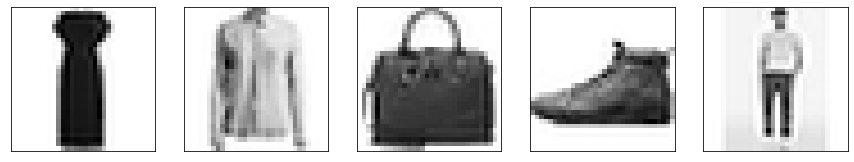

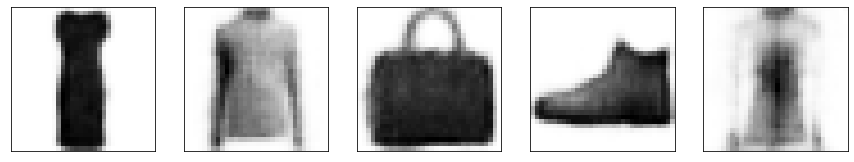

In [5]:
conv_ae.test_encoder(5)

In [6]:
env = Environment(dataset = tf.keras.datasets.mnist)
conv_ae = ConvoAutoEncoder(env, filters = (16, 24, 32), bottle_neck_size = 20 )
conv_ae.run_training(1000)
conv_ae.model.summary()


11493376/11490434 [==============================] - 0s 0us/step
Input shape = 
(60000, 32, 32, 1)

Data type = 
<class 'numpy.float32'>

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 24)        3480      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 24)      

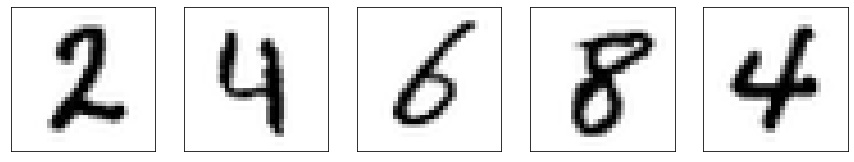

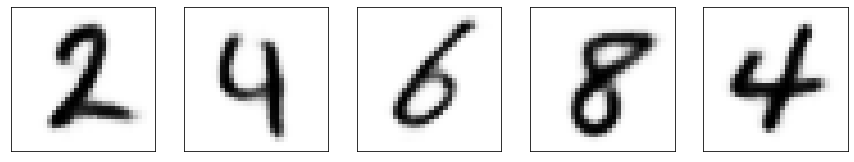

In [7]:
conv_ae.test_encoder(5)

In [8]:
env = Environment(dataset = tf.keras.datasets.cifar10)
conv_ae = ConvoAutoEncoder(env, filters = (64, 128), bottle_neck_size = 200 )
conv_ae.run_training(1000)

170500096/170498071 [==============================] - 4s 0us/step
Input shape = 
(50000, 32, 32, 3)

Data type = 
<class 'numpy.float32'>

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 16, 16, 128)   

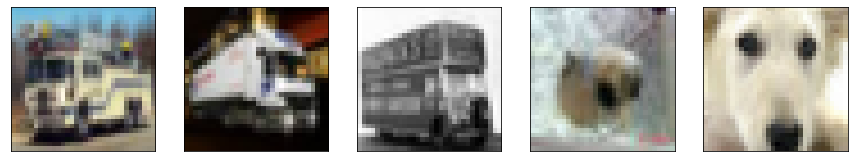

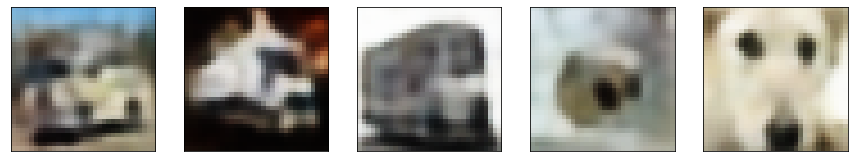

In [9]:
conv_ae.test_encoder(5)